In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from init_objects import *
from functions.helpers import organise_data
from qe_model import *
from matplotlib import style
import math
import scipy.stats as stats
import statsmodels.api as sm
#from functions.find_bubbles import *
import matplotlib.transforms as mtransforms

In [2]:
style.use('seaborn-ticks')

In [3]:
def confidence_interval(data, av):
    sample_stdev = np.std(data)
    sigma = sample_stdev/math.sqrt(len(data))
    return stats.t.interval(alpha = 0.95, df= 24, loc=av, scale=sigma) 

# Model dynamics

In [4]:
NRUNS = 5
burn_in_period = 0

In [5]:
#scenarios = [None, 'BLR', 'BUSTQE', 'BUSTQT', 'BOOMQE', 'BOOMQT']
scenarios = [None, 'BLR', 'BUSTQE', 'BOOMQT']

In [6]:
params_nb = {"fundamental_value": 105,
              "trader_sample_size": 15, "n_traders": 500,
              "ticks": 500, "std_fundamental": 0.01,
              "std_noise": 0.159, "w_random": 0.25,
              "strat_share_chartists": 0.20,
              "init_assets": 740, "base_risk_aversion": 4.051,
              'spread_max': 0.004, "horizon": 200,
              "fundamentalist_horizon_multiplier": 2.2,
              "trades_per_tick": 3, "mutation_intensity": 0.0477,
              "average_learning_ability": 0.02, 'money_multiplier': 2.2,
              "bond_mean_reversion": 0.0, 'cb_pf_range': 0.05,
              "qe_perc_size": 0.16, "cb_size": 0.02, "qe_asset_index": 0}

In [7]:
prices = []
fundamentals = []
volumes = []
qe_periods = []
qt_periods = []
cb_asset_values = []
cb_currencies = []

for scenario in scenarios:
    trdrs = []
    orbs = []
    central_banks = []

    for seed_nb in range(NRUNS): 
        traders_nb, central_bank_nb, orderbook_nb = init_objects(params_nb, seed_nb)
        traders_nb, central_bank_nb, orderbook_nb = qe_model(traders_nb, central_bank_nb, orderbook_nb, params_nb, scenario=scenario, seed=seed_nb)
        central_banks.append(central_bank_nb)
        trdrs.append(traders_nb)
        orbs.append(orderbook_nb)
    
    prices.append(pd.DataFrame([orbs[run].tick_close_price for run in range(NRUNS)]).transpose())
    fundamentals.append(pd.DataFrame([orbs[run].fundamental for run in range(NRUNS)]).transpose())
    volumes.append(pd.DataFrame([[sum(v) for v in orbs[run].transaction_volumes_history] for run in range(NRUNS)]).transpose())
    qe_periods.append(pd.DataFrame([[orbs[run].qe_period] for run in range(NRUNS)]).transpose())
    qt_periods.append(pd.DataFrame([[orbs[run].qt_period] for run in range(NRUNS)]).transpose())
    
    cb_asset_values.append(pd.DataFrame([np.array(orbs[run].tick_close_price[2:]) * np.array(central_banks[run].var.assets) for run in range(NRUNS)]).transpose())
    cb_currencies.append(pd.DataFrame([central_banks[run].var.currency for run in range(NRUNS)]).transpose())
    

Start of simulation  0
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443

216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
46

667
668
cb QT
cb QT
cb QT
669
cb QT
cb QT
670
671
672
673
674
cb QT
cb QT
675
676
cb QT
cb QT
cb QT
677
cb QT
cb QT
cb QT
678
cb QT
cb QT
cb QT
679
cb QT
cb QT
cb QE
680
cb QE
cb QE
cb QE
681
cb QE
cb QE
cb QE
682
cb QE
683
684
685
686
cb QE
cb QE
687
cb QE
cb QE
cb QE
688
689
690
691
692
693
694
695
696
697
698
cb QE
cb QE
699
cb QE
700
cb QE
cb QE
Start of simulation  1
201
202
203
cb QT
cb QT
cb QT
204
cb QT
cb QT
cb QT
205
cb QT
cb QT
cb QT
206
207
cb QT
208
cb QT
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
cb QT
211
212
cb QT
cb QT
cb QT
213
cb QT
cb QT
cb QT
214
cb QT
cb QT
cb QT
215
cb QT
cb QT
cb QT
216
cb QT
cb QT
cb QT
217
218
219
220
221
222
cb QE
223
cb QE
cb QE
cb QE
224
cb QE
cb QE
cb QE
225
cb QE
cb QE
cb QE
226
cb QE
cb QE
227
cb QE
228
cb QE
cb QE
cb QE
229
cb QE
cb QE
cb QE
230
cb QE
cb QE
cb QE
231
cb QE
cb QE
cb QE
232
cb QE
cb QE
cb QE
233
cb QE
cb QE
cb QE
234
235
cb QE
cb QE
cb QE
236
cb QE
237
cb QT
cb QT
cb QT
238
cb QT
cb QT
cb QT
239
cb QT
cb QT
cb QT
240
cb 

255
cb QE
cb QE
256
257
cb QE
cb QE
cb QE
258
cb QE
cb QE
259
cb QE
cb QE
260
cb QE
cb QE
cb QE
261
cb QT
cb QT
cb QT
262
263
264
cb QT
cb QT
265
cb QT
cb QT
cb QT
266
cb QT
cb QT
cb QT
267
cb QT
cb QT
cb QT
268
cb QT
cb QT
cb QT
269
270
271
272
273
274
275
cb QE
cb QE
cb QE
276
cb QE
cb QE
cb QE
277
cb QE
cb QE
cb QE
278
cb QE
cb QE
cb QE
279
cb QE
cb QE
cb QE
280
cb QE
cb QE
cb QE
281
cb QT
cb QT
cb QT
282
cb QT
cb QT
cb QT
283
cb QT
cb QT
cb QT
284
cb QT
cb QT
cb QT
285
cb QT
cb QT
cb QT
286
287
cb QT
cb QT
cb QT
288
cb QE
289
cb QE
cb QE
cb QE
290
cb QE
cb QE
cb QE
291
cb QE
cb QE
cb QE
292
cb QE
cb QE
cb QE
293
cb QE
cb QE
cb QE
294
cb QE
cb QE
cb QE
295
cb QE
cb QE
296
cb QE
cb QE
cb QE
297
cb QE
cb QE
cb QE
298
cb QE
cb QE
299
cb QE
cb QE
cb QE
300
cb QE
301
cb QT
cb QT
cb QT
302
cb QT
cb QT
cb QT
303
cb QT
cb QT
cb QT
304
cb QT
cb QT
cb QT
305
cb QT
cb QT
cb QT
306
cb QT
cb QT
cb QT
307
cb QT
cb QT
308
309
310
311
cb QE
cb QE
312
cb QE
cb QE
cb QE
313
cb QE
cb QE
cb QE
314
cb Q

334
cb QE
cb QE
335
cb QE
cb QE
cb QE
336
cb QE
cb QE
cb QE
337
cb QE
cb QE
cb QE
338
cb QE
cb QE
cb QE
339
cb QE
cb QT
cb QT
340
cb QT
cb QT
cb QT
341
cb QT
cb QT
cb QT
342
cb QT
cb QT
cb QT
343
cb QT
cb QT
cb QT
344
cb QT
345
346
cb QE
cb QE
347
cb QE
cb QE
cb QE
348
cb QE
cb QE
349
350
351
cb QT
352
cb QT
cb QT
cb QT
353
cb QT
cb QT
cb QT
354
cb QT
cb QT
355
356
cb QT
cb QT
cb QT
357
cb QT
358
359
360
361
362
363
cb QT
cb QT
364
cb QT
cb QT
cb QT
365
cb QT
cb QT
cb QT
366
cb QT
cb QT
367
368
369
370
371
372
cb QE
cb QE
373
cb QE
cb QE
cb QE
374
cb QE
cb QE
cb QE
375
cb QE
cb QE
cb QE
376
cb QE
cb QE
cb QT
377
cb QT
378
379
cb QT
cb QT
380
cb QT
cb QT
381
cb QT
cb QT
cb QT
382
383
cb QT
cb QT
384
cb QT
cb QT
cb QT
385
386
cb QT
cb QT
cb QT
387
cb QT
cb QT
cb QT
388
cb QT
389
cb QT
cb QT
cb QT
390
cb QT
cb QT
cb QT
391
cb QT
cb QT
cb QT
392
cb QT
cb QT
cb QT
393
cb QT
cb QT
cb QT
394
cb QT
cb QT
cb QT
395
cb QT
cb QT
cb QT
396
cb QT
cb QT
cb QT
397
cb QT
cb QT
cb QT
398
cb QT
cb QT
cb

cb QE
cb QE
372
cb QE
cb QE
373
cb QT
374
cb QT
cb QT
cb QT
375
cb QT
cb QT
cb QT
376
cb QT
cb QT
377
378
cb QE
379
cb QE
cb QE
cb QE
380
cb QE
381
cb QE
cb QE
cb QE
382
cb QE
cb QE
cb QE
383
cb QE
cb QE
cb QE
384
cb QE
cb QE
385
386
387
388
389
390
391
392
393
394
395
cb QE
396
cb QE
cb QE
cb QE
397
cb QE
cb QE
cb QE
398
cb QE
cb QE
cb QE
399
cb QE
cb QE
400
cb QT
401
cb QT
cb QT
cb QT
402
cb QT
cb QT
cb QT
403
cb QT
cb QT
404
cb QT
cb QT
cb QT
405
cb QT
cb QT
cb QT
406
cb QT
cb QT
cb QT
407
cb QT
408
409
410
411
cb QT
cb QT
cb QT
412
cb QT
413
414
415
416
417
418
419
debug
cb QE
420
cb QE
cb QE
cb QE
421
cb QE
cb QE
cb QE
422
cb QE
423
424
425
426
cb QT
427
cb QT
cb QT
cb QT
428
cb QT
cb QT
cb QT
429
cb QT
cb QT
cb QT
430
cb QT
cb QT
cb QT
431
cb QT
cb QT
cb QT
432
cb QT
cb QT
cb QT
433
cb QT
cb QT
cb QT
434
cb QT
cb QT
435
436
437
438
439
440
cb QE
cb QE
cb QE
441
cb QE
cb QE
cb QE
442
cb QE
cb QE
cb QE
443
cb QE
cb QE
cb QE
444
cb QE
445
cb QE
cb QE
cb QE
446
cb QE
cb QE
cb QE
447


510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
cb QE
527
cb QE
cb QE
cb QE
528
cb QE
cb QE
529
cb QE
cb QE
cb QE
530
cb QE
cb QE
531
cb QE
cb QE
cb QE
532
cb QE
cb QE
cb QE
533
cb QE
cb QE
534
535
536
537
cb QE
cb QE
cb QE
538
cb QE
cb QE
cb QE
539
cb QE
cb QE
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  2
201
202
203
204
205
cb QE
cb QE
206
cb QE
cb QE
cb 

669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
Start of simulation  0
201
202
203
204
205
206
207
208
cb QT
cb QT
209
cb QT
cb QT
cb QT
210
cb QT
cb QT
cb QT
211
cb QT
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
cb QT
cb QT
335
cb QT
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
3

395
cb QT
cb QT
cb QT
396
cb QT
cb QT
cb QT
397
cb QT
cb QT
cb QT
398
cb QT
cb QT
cb QT
399
cb QT
cb QT
400
cb QT
cb QT
cb QT
401
cb QT
cb QT
cb QT
402
cb QT
cb QT
403
cb QT
cb QT
404
405
406
407
408
409
410
411
412
413
414
415
416
417
cb QT
cb QT
418
cb QT
419
debug
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602


## For BustQE, BoomQT & BLR show:

Prices compared to no-QE + cb balance sheet. 

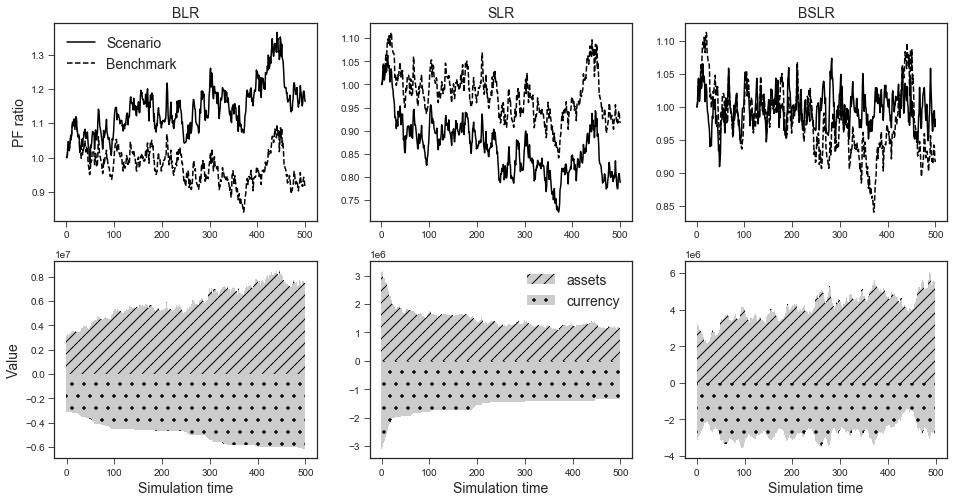

In [95]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16,8))

# price BLR
s_idx = 2
ax1.set_title('BLR', fontsize='14')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1), 'k-', label='Scenario')
ax1.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1), 'k--', label='Benchmark')
ax1.set_ylabel('PF ratio', fontsize='14')
ax1.legend(loc='best', fontsize='14')

# price SLR
s_idx = 3
ax2.set_title('SLR', fontsize='14')
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1), 'k-', label=scenarios[s_idx])
ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1), 'k--', label='Benchmark')
#ax2.set_ylabel('Price')

# price BSLR
s_idx = 1
ax3.set_title('BSLR', fontsize='14')
ax3.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1), 'k-', label=scenarios[s_idx])
ax3.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1), 'k--', label='Benchmark')
#ax3.set_ylabel('Price')

# Central bank balance sheets
ax4.bar(cb_asset_values[2].index, cb_asset_values[2].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax4.bar(cb_currencies[2].index, cb_currencies[2].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')
ax4.set_ylabel('Value', fontsize='14')

# Central bank balance sheets
ax5.bar(cb_asset_values[3].index, cb_asset_values[3].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax5.bar(cb_currencies[3].index, cb_currencies[3].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')
ax5.legend(loc='best', fontsize='14')

# Central bank balance sheets
ax6.bar(cb_asset_values[1].index, cb_asset_values[1].mean(axis=1), label='assets', width=1.0, alpha=0.4, color='grey', hatch='//')
ax6.bar(cb_currencies[1].index, cb_currencies[1].mean(axis=1), label='currency', width=1.0, alpha=0.4, color='grey', hatch='.')

for ax in (ax4, ax5, ax6):
    ax.set_xlabel('Simulation time', fontsize='14')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

fig.savefig('qe_dynamics.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

## Record some statistics: 

- av price + conf intervals
- volatilty + conf intervals

In [77]:
av_pf_baseline = (prices[0].mean(axis=0) / fundamentals[0].mean(axis=0)).mean()
lower_baseline, upper_baseline = confidence_interval((prices[0].mean(axis=0) / fundamentals[0].mean(axis=0)), av_pf_baseline)

# BLR
av_p_blr = (prices[2].mean(axis=0) / fundamentals[2].mean(axis=0)).mean()
lower_blr, upper_blr = confidence_interval((prices[2].mean(axis=0) / fundamentals[2].mean(axis=0)), av_p_blr)

# SLR
av_p_slr = (prices[3].mean(axis=0) / fundamentals[3].mean(axis=0)).mean()
lower_slr, upper_slr = confidence_interval((prices[3].mean(axis=0) / fundamentals[3].mean(axis=0)), av_p_slr)

# BSLR
av_p_bslr = (prices[1].mean(axis=0) / fundamentals[1].mean(axis=0)).mean()
lower_bslr, upper_bslr = confidence_interval((prices[1].mean(axis=0) / fundamentals[1].mean(axis=0)) , av_p_bslr)

In [78]:
print('Price effect')
print('Baseline', av_pf_baseline)
print('conf', lower_baseline, upper_baseline)
print('BLR', av_p_blr)
print('conf', lower_blr, upper_blr)
print('SLR', av_p_slr)
print('conf', lower_slr, upper_slr)
print('BSLR', av_p_bslr)
print('conf', lower_bslr, upper_bslr)

Price effect
Baseline 0.9785349141433809
conf 0.9513236360151927 1.0057461922715691
BLR 1.1412703623128158
conf 1.1046766154233298 1.1778641092023017
SLR 0.8644200536140592
conf 0.8482063096306663 0.880633797597452
BSLR 0.9972409542955806
conf 0.996167276742881 0.9983146318482802


In [90]:
# extract cycle and trend for the 4 series
baseline_cycle, baseline_trend = sm.tsa.filters.hpfilter((prices[0] / fundamentals[0]).iloc[:-1], lamb=100000000)

baseline_detr_stdev = np.mean(baseline_cycle.std())
baseline_lower_std, baseline_upper_std = confidence_interval(baseline_cycle.std(), np.mean(baseline_cycle.std()))

# BLR
blr_cycle, blr_trend = sm.tsa.filters.hpfilter((prices[2] / fundamentals[2]).iloc[:-1], lamb=100000000)
blr_detr_stdev = np.mean(blr_cycle.std())
blr_lower_std, blr_upper_std = confidence_interval(blr_cycle.std(), np.mean(blr_cycle.std()))

# SLR
slr_cycle, slr_trend = sm.tsa.filters.hpfilter((prices[3] / fundamentals[3]).iloc[:-1], lamb=100000000)
slr_detr_stdev = np.mean(slr_cycle.std())
slr_lower_std, slr_upper_std = confidence_interval(slr_cycle.std(), np.mean(slr_cycle.std()))

# BSLR
bslr_cycle, bslr_trend = sm.tsa.filters.hpfilter((prices[1] / fundamentals[1]).iloc[:-1], lamb=100000000)
bslr_detr_stdev = np.mean(bslr_cycle.std())
bslr_lower_std, bslr_upper_std = confidence_interval(bslr_cycle.std(), np.mean(bslr_cycle.std()))

In [92]:
print('Stdev effect')
print('Baseline', baseline_detr_stdev)
print('conf', baseline_lower_std, baseline_upper_std)
print('BLR', blr_detr_stdev)
print('conf', blr_lower_std, blr_upper_std)
print('SLR', slr_detr_stdev)
print('conf', slr_lower_std, slr_upper_std)
print('BSLR', bslr_detr_stdev)
print('conf', bslr_lower_std, bslr_upper_std)

Stdev effect
Baseline 0.0882135440460771
conf 0.07234126447975064 0.10408582361240357
BLR 0.10609778055574086
conf 0.0903856090685685 0.12180995204291321
SLR 0.08042143990599576
conf 0.06590078356120158 0.09494209625078995
BSLR 0.05550674421803521
conf 0.05108739300687359 0.059926095429196836


# BLR

Text(0, 0.5, 'Volume')

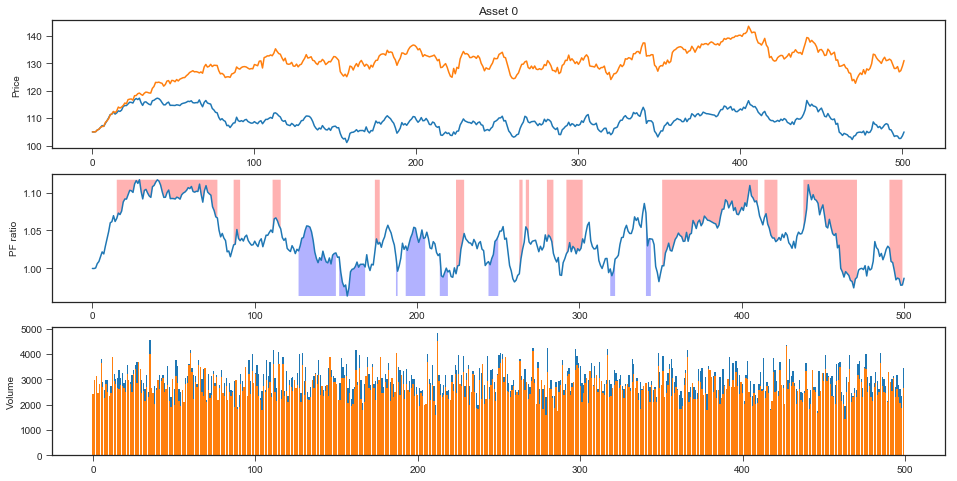

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 1

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Bust QE

Text(0, 0.5, 'Volume')

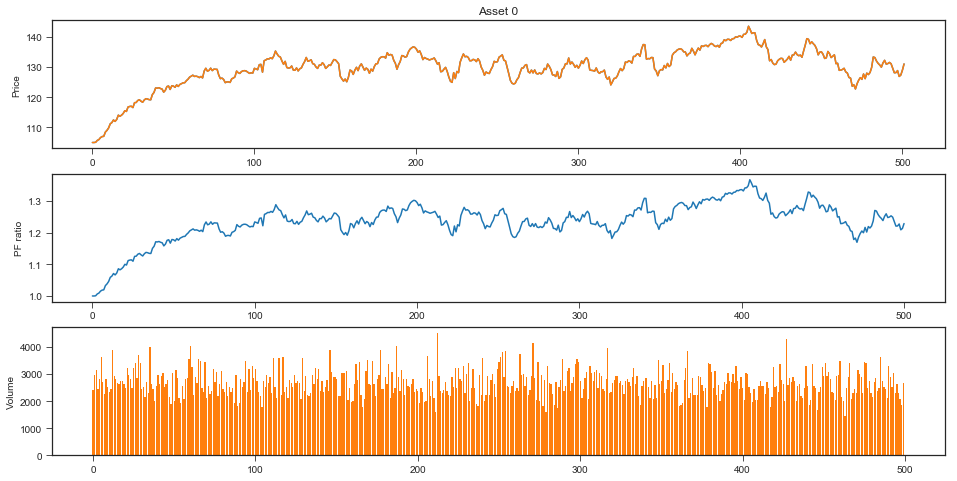

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 2

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Bust QT

Text(0, 0.5, 'Volume')

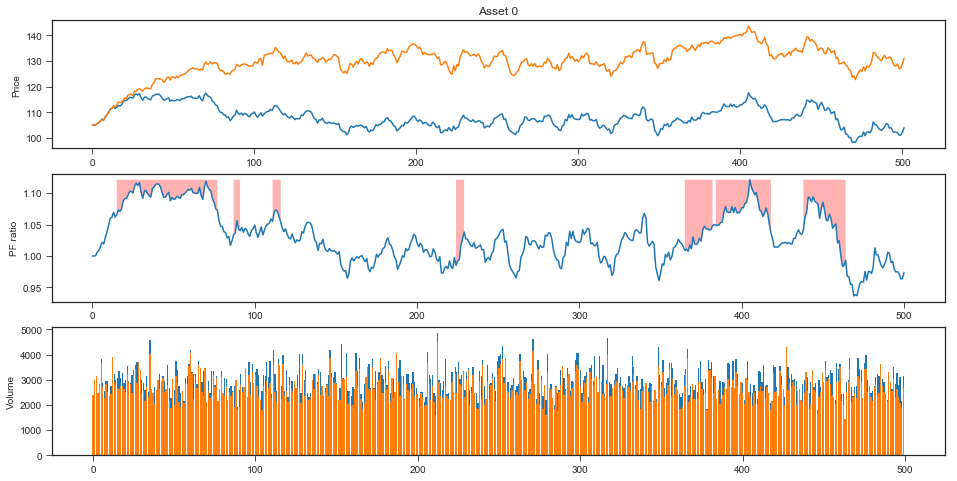

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 3

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Boom QE

IndexError: list index out of range

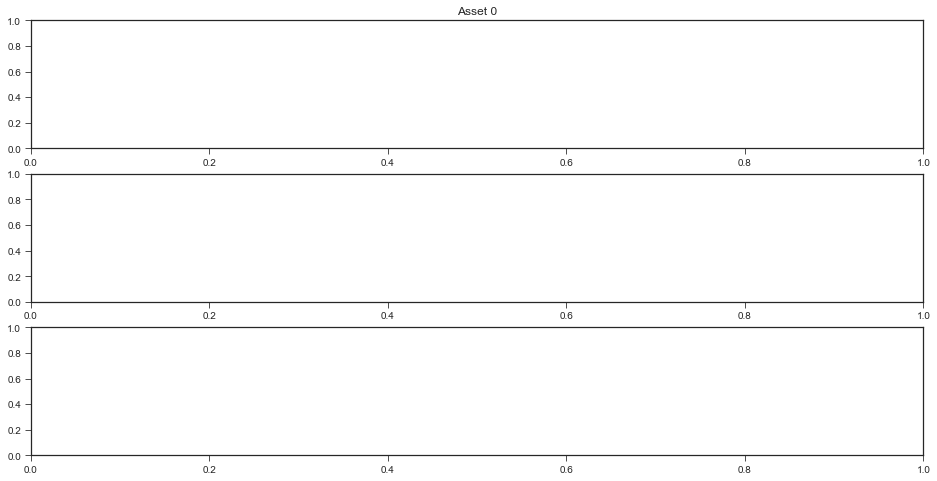

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 4

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Boom QT

IndexError: list index out of range

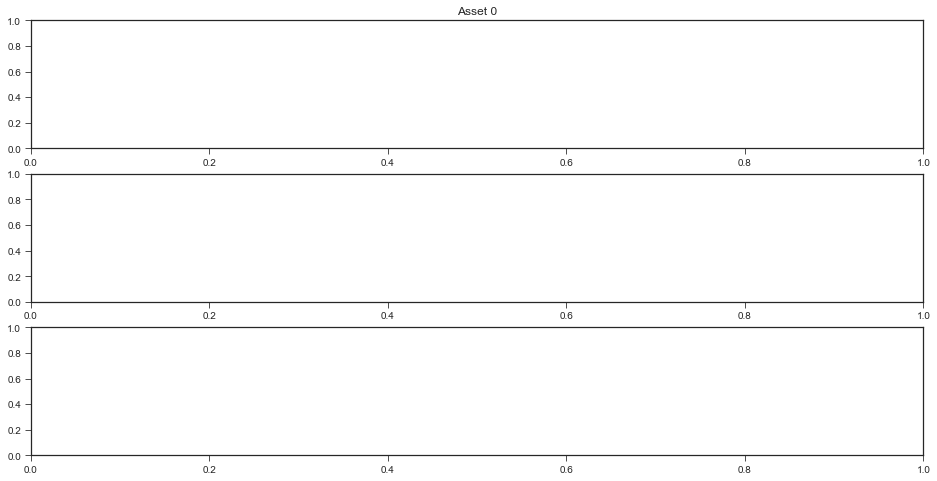

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16,8))

s_idx = 5

# prices
ax1.set_title('Asset 0')
ax1.plot(prices[s_idx].index, prices[s_idx].mean(axis=1), label=scenarios[s_idx])
ax1.plot(prices[0].index, prices[0].mean(axis=1), label='Benchmark')
ax1.set_ylabel('Price')

# pd ratio's 
#ax2.plot(prices[0].index, prices[0].mean(axis=1) / fundamentals[0].mean(axis=1))
ax2.plot(prices[s_idx].index, prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 min(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qe_periods[s_idx].iloc[0][0], 
                 facecolor='blue', alpha=0.3)
ax2.fill_between(list(prices[s_idx].index)[:-2], (prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1))[:-2], 
                 max(prices[s_idx].mean(axis=1) / fundamentals[s_idx].mean(axis=1)), where= qt_periods[s_idx].iloc[0][0], 
                 facecolor='red', alpha=0.3)
ax2.set_ylabel('PF ratio')

# # volumes
ax3.bar(volumes[s_idx].index, volumes[s_idx].mean(axis=1))
ax3.bar(volumes[0].index, volumes[0].mean(axis=1))
ax3.set_ylabel('Volume')

# Summary 